# Identificación de puntos de interés turísticos en Barcelona

Mediante el uso de métodos de clasificación no supervisados se pueden identificar cuales con los puntos de interés turisticos a través de los metadatos de las fotografías de flickr. 

Daniel Núñez

In [1]:
import random

import numpy as np
import pandas as pd
from sklearn import cluster      
from sklearn import datasets     
from sklearn import manifold     

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Se busca automatizar la localización de lugares turísticos a través de los metadatos de las fotografías de flickr.
Para ello se utiliza el dataset: ``barcelona.csv``.

In [31]:
# Cargamos la base y la vemos
bcn = pd.read_csv('barcelona.csv', header=0)
bcn.head(5)

,latitude,longitude
0,41.413766,2.152934
1,41.385719,2.170049
2,41.390911,2.196321
3,41.419326,2.154521
4,41.419326,2.154521


Visualizamos las localizaciones de las fotografías mediante un scatter plot y probamos distintos parámetros de tamaño (<i>size</i>) <i>s</i>, y opacidad <i>alpha</i> hasta conseguir un resultado fácil de interpretar. 
</div>

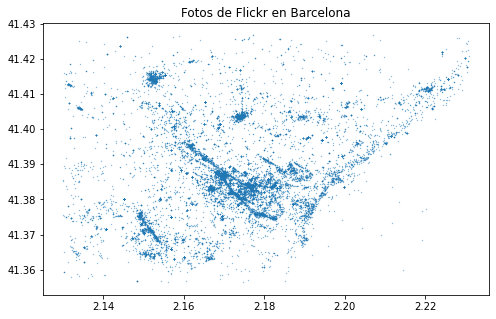

In [32]:
# Hacemos la figura
plt.figure(figsize=(8,5))
# Hacemos el scatter y le ponemos un tamaño muy pequeño a los puntos
# para que se vea bien la parte geografica pero tambien donde se concentran más
plt.scatter(bcn["longitude"], bcn["latitude"], alpha = 0.7, s=0.1)
plt.title("Fotos de Flickr en Barcelona")
plt.show()

Tras haber probado varios algoritmos de agrupamiento, el DBSCAN será el mas adecuado ya que como vemos en el grafico los grupos tienen ciertas formas por lo que será mas facil encontrarlos si nos basamos en la cernania de los puntos y no en centroides como hace kmeans.

Para prototipar el modelado, primero se elige un subconjunto de los datos que sea representativo. Se selecciona una muestra del DataFrame original y se visualiza como en el punto anterior para comprobar su similitud. 

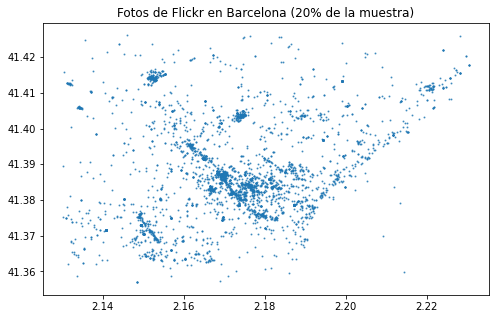

In [33]:
# Sacamos una muestra del 20% del datset
bcn_sample = bcn.sample(frac=0.2)
#Hacemos el mismo grafico de antes pero solo con la muestra
plt.figure(figsize=(8,5))
plt.scatter(bcn_sample["longitude"], bcn_sample["latitude"], alpha = 0.7, s=1)
plt.title("Fotos de Flickr en Barcelona (20% de la muestra)")
plt.show()

Ajustamos el algoritmo de clustering elegido para encontrar los distintos grupos sobre el conjunto reducido, y visualizamos el resultado coloreando cada punto en base al grupo al que pertenece.

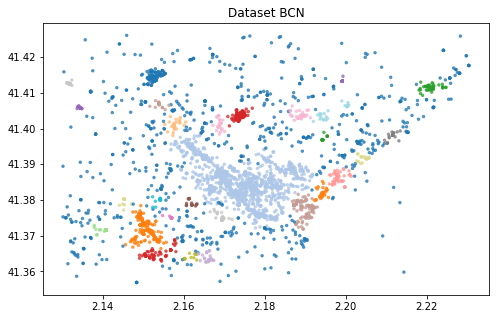

In [34]:
# Hacemos un modelo dbscan con una distancia muy pequeña entre elementos y marcando un minimo de 15 elementos
# para poder formar un grupo
Modelo = cluster.DBSCAN(eps = 0.0019, min_samples = 15).fit(bcn_sample)
# Aplicamos y guardamos el modelo en una variable
grupos = Modelo.fit(bcn_sample)
# Hacemos un grafico que muestra los grupos 
plt.figure(figsize=(8,5))
plt.scatter(bcn_sample.longitude, bcn_sample.latitude, c = grupos.labels_, alpha = 0.7, s=6,cmap="tab20")
plt.title('Dataset ' + str("BCN"))
plt.show()

Como hemos usado un método de <i>clustering</i> que permite la detección de <i>outliers</i>, representamos sólo los puntos que no ha considerado <i>outliers</i>, es decir, los que pertenecen a algún <i>cluster</i>.


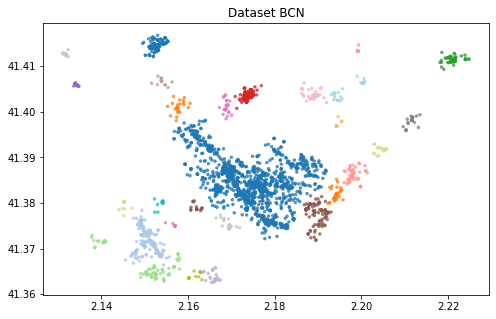

Numero de clusters: 30


In [43]:
# Hacemos un nuevo data frame que contenga las etiquetas de los grupos anteriores
bcn_grupos = pd.DataFrame()
bcn_grupos['latitude']=bcn_sample['latitude'].values
bcn_grupos['longitude']=bcn_sample['longitude'].values
bcn_grupos['label'] = grupos.labels_
# Eliminamos los outliers del nuevo data frame. Se corresponden con la etiqueta -1
bcn_grupos = bcn_grupos.drop(bcn_grupos[bcn_grupos['label'] == -1].index)
# Hacemos el grafico con la nueva base que no tiene outilers 
plt.figure(figsize=(8,5))
plt.scatter(bcn_grupos.longitude, bcn_grupos.latitude, c = bcn_grupos.label, alpha = 0.7, s=6,cmap="tab20")
plt.title('Dataset ' + str("BCN"))
plt.show()

print("Numero de clusters: " + str(len(np.unique(grupos.labels_))))

Si comparamos el gráfico de los clusters con un mapa de Barcelona, podemos ver ciertas similitudes entre ellos. Vemos que los grupos se han hecho según las zonas más turísticas de Barcelona. Al final, tiene sentido que cada uno de los grupos represente un moumento, jardin o punto turístico de interes de la ciudad ya que los datos son las ubicaciones de fotos y donde uno se hace más fotos es en ubicaciones turisticas.

Representamos los puntos sin ruido sobre un mapa utilizando la librería <a href="https://pypi.org/project/smopy/">Smopy</a>. Para facilitar la interpretación, puedes representar cada cluster como el punto medio de todos los puntos que lo conforman.

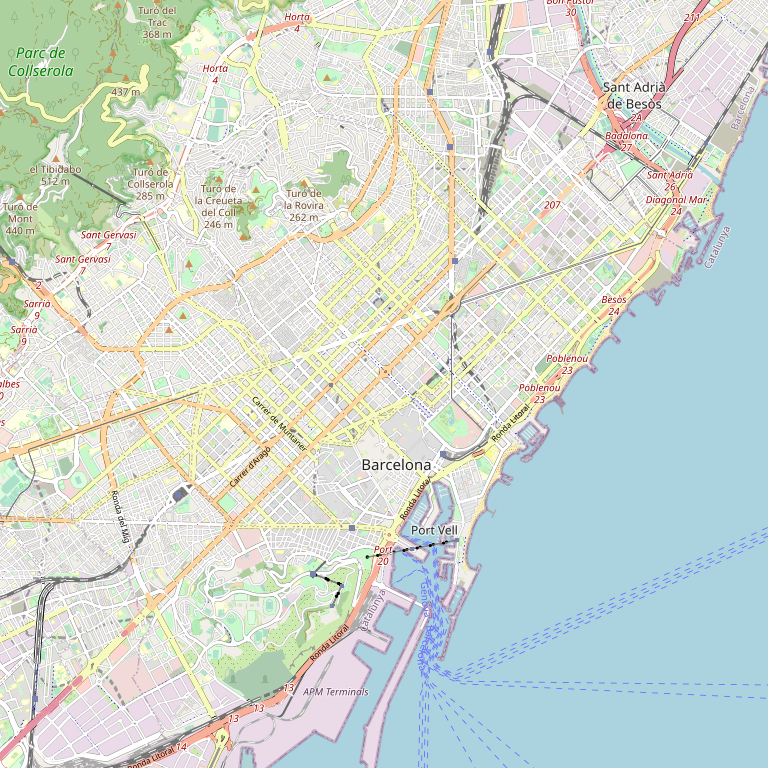

In [36]:
import smopy
# Ponemos las coordenadas que estan por encima, debajo, izquierda y derecha de barcelona 
# con un zoom bastante grande. Guardamos el mapa
map = smopy.Map((41.354937, 2.129366, 41.427373,  2.218903),z=13)
# Vemos el mapa
map.show_ipython()

<ipython-input-42-03f6026dbb09>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bcn_grupos['color'][i] = colores_grupos(z)


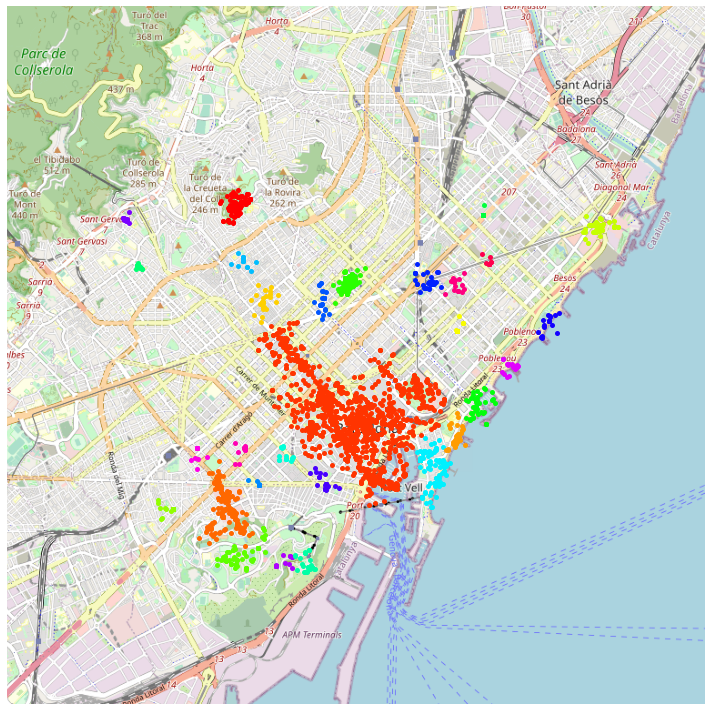

In [42]:
# Creamos una nueva variable donde vamos a asignarle un color a cada cluster
bcn_grupos['color'] = ""
# Cogemos de una paleta de colores 30 colores que seran los que pongamos a los grupos
colores_grupos = plt.cm.get_cmap('hsv', 30)
# Hacemos un bucle para asignar los colores en la nueva variable por grupo
for i in list(bcn_grupos.longitude.index):
    for z in range(30):
        if bcn_grupos['label'][i] == z :
            bcn_grupos['color'][i] = colores_grupos(z)
# Hacemos una figura para el mapa
ax = map.show_mpl(figsize=(10, 10))
# Hacemos un bucle donde vamos pintando punto por punto todos los elementos segun sus coordenadas
# y ponemos a cada uno su color
for i in list(bcn_grupos.longitude.index):
    x, y = map.to_pixels( bcn_grupos.latitude[i], bcn_grupos.longitude[i])
    ax.plot(x, y, 'o', ms=3, mew=2, c = bcn_grupos['color'][i])
